# RTA workload

The RTA or RTApp workload represents a type of workload obtained using the rt-app test application.
More details on the test application can be found at https://github.com/scheduler-tools/rt-app.

In [1]:
import logging
from conf import LisaLogging
LisaLogging.setup(level=0)

2018-01-19 11:30:45,730 INFO    : root         : Using LISA logging configuration:
2018-01-19 11:30:45,731 INFO    : root         :   /home/leoy/Work/tools/lisa-ml-20171106/logging.conf


In [2]:
# Generate plots inline
%pylab inline

import json
import os

# Support to initialise and configure your test environment
import devlib
from env import TestEnv

# Support to configure and run RTApp based workloads
from wlgen import RTA, Periodic, Ramp, Step, Pulse

# Suport for FTrace events parsing and visualization
import trappy

# Support for performance analysis of RTApp workloads
from perf_analysis import PerfAnalysis

%matplotlib inline

import devlib
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import re
import trappy

from collections import OrderedDict
from csv import DictWriter
from env import TestEnv
from matplotlib.ticker import FormatStrFormatter, MaxNLocator
from scipy.stats import linregress
from scipy import polyfit
from time import sleep
from trappy.plotter.ColorMap import ColorMap

# Support for trace events analysis
from trace import Trace
# Import support for Android devices
from android import Screen, Workload, System

Populating the interactive namespace from numpy and matplotlib


2018-01-19 11:30:49,510 DEBUG   : JsonConf     : loading JSON...
2018-01-19 11:30:49,521 DEBUG   : JsonConf     : Loaded JSON configuration:
2018-01-19 11:30:49,522 DEBUG   : JsonConf     :    {u'board': {u'big_core': u'A15', u'cores': [u'A7', u'A7', u'A7', u'A7', u'A15', u'A15', u'A15', u'A15'], u'modules': [u'bl', u'cpufreq']}}
2018-01-19 11:30:49,526 DEBUG   : JsonConf     : loading JSON...
2018-01-19 11:30:49,529 DEBUG   : JsonConf     : Loaded JSON configuration:
2018-01-19 11:30:49,530 DEBUG   : JsonConf     :    {u'nrg_model': {u'big': {u'cluster': {u'nrg_max': 78}, u'cpu': {u'cap_max': 1024, u'nrg_max': 1893}}, u'little': {u'cluster': {u'nrg_max': 56}, u'cpu': {u'cap_max': 472, u'nrg_max': 215}}}, u'board': {u'big_core': u'A72', u'cores': [u'A53', u'A53', u'A53', u'A53', u'A72', u'A72'], u'modules': [u'bl', u'cpufreq', u'cpuidle']}}
2018-01-19 11:30:49,531 DEBUG   : JsonConf     : loading JSON...
2018-01-19 11:30:49,533 DEBUG   : JsonConf     : Loaded JSON configuration:
2018-0

## Test environment setup

For more details on this please check out **examples/utils/testenv_example.ipynb**.

In [3]:
# Setup a target configuration
my_target_conf = {
    
    # Define the kind of target platform to use for the experiments
    "platform"    : 'android',  # Linux system, valid other options are:
                              # android - access via ADB
                              # linux   - access via SSH
                              # host    - direct access
    
    # Energy Meters Configuration for BayLibre's ACME Cape
    "emeter" : {
        "instrument" : "aep",
        "conf" : {
            'resistor_values' : [0.033],
            'device_entry'    : '/dev/ttyACM0'
        },
        "channel_map" : {
            "Device0" : "BAT"
        }
    },
    
    # Preload settings for a specific target
    "board"       : 'hikey960',  # juno - JUNO board with mainline hwmon
    
    "device"      : "2450309301A1C7FB",
    
    "modules" : ['cpufreq', 'cpuidle', 'hotplug', 'cgroups', 'thermal', 'cpufreq'],

    "results_dir" : "scheduling_duration_base",
    
    # Comment the following line to force rt-app calibration on your target
    "rtapp-calib" : {
         '0': 302, '1': 301, '2': 304, '3': 301, '4': 136, '5': 136, '6': 137, '7': 136
    }

}

# Setup the required Test Environment supports
my_tests_conf = {
    
    # Binary tools required to run this experiment
    # These tools must be present in the tools/ folder for the architecture
    "tools"   : ['rt-app', 'taskset', 'trace-cmd'],
    
    # FTrace events end buffer configuration
    "ftrace"  : {
         "events" : [
             "sched_switch",
             "cpu_frequency",
             "sched_energy_calc_duration"
         ],
         "buffsize" : 10240
    },

}

In [5]:
# Initialize a test environment using
# - the provided target configuration (my_target_conf)
# - the provided test configuration   (my_test_conf)
te = TestEnv(target_conf=my_target_conf, test_conf=my_tests_conf)
target = te.target

2018-01-19 11:31:04,350 INFO    : TestEnv      : Using base path: /home/leoy/Work/tools/lisa-ml-20171106
2018-01-19 11:31:04,351 INFO    : TestEnv      : Loading custom (inline) target configuration
2018-01-19 11:31:04,352 INFO    : TestEnv      : Loading custom (inline) test configuration
2018-01-19 11:31:04,354 WARNING : TestEnv      : Wipe previous contents of the results folder:
2018-01-19 11:31:04,355 WARNING : TestEnv      :    /home/leoy/Work/tools/lisa-ml-20171106/results/scheduling_duration_base
2018-01-19 11:31:04,357 INFO    : TestEnv      : External tools using:
2018-01-19 11:31:04,359 INFO    : TestEnv      :    ANDROID_HOME: /home/leoy/Android/Sdk/
2018-01-19 11:31:04,360 INFO    : TestEnv      :    CATAPULT_HOME: /home/leoy/Work/tools/lisa-ml-20171106/tools/catapult
2018-01-19 11:31:04,362 INFO    : TestEnv      : Devlib modules to load: ['cgroups', 'cpufreq', 'bl', 'hotplug', 'thermal', 'cpuidle']
2018-01-19 11:31:04,363 INFO    : TestEnv      : Connecting Android targe

2018-01-19 11:31:08,682 DEBUG   : CGroup.debug : Initialized [debug, 0, ['blkio', 'devices', 'freezer', 'hugetlb', 'debug']]
2018-01-19 11:31:08,767 DEBUG   : CGroup.debug : Controller debug mounted under: /data/local/tmp/devlib-target/cgroups/devlib_cgh0 (noprefix=False)
2018-01-19 11:31:08,769 DEBUG   : cgroups.debug : Creating cgroup /data/local/tmp/devlib-target/cgroups/devlib_cgh0
2018-01-19 11:31:08,828 INFO    : CGroups      :   debug        : /data/local/tmp/devlib-target/cgroups/devlib_cgh0
2018-01-19 11:31:10,945 INFO    : TestEnv      : Attempting to read energy model from target
2018-01-19 11:31:11,719 INFO    : TestEnv      : Topology:
2018-01-19 11:31:11,721 INFO    : TestEnv      :    [[0, 1, 2, 3], [4, 5, 6, 7]]
2018-01-19 11:31:11,862 INFO    : TestEnv      : Loading default EM:
2018-01-19 11:31:11,863 INFO    : TestEnv      :    /home/leoy/Work/tools/lisa-ml-20171106/libs/utils/platforms/hikey960.json
2018-01-19 11:31:11,864 DEBUG   : JsonConf     : loading JSON...
20

## Workload configuration

To create an instance of an RTApp workload generator you need to provide the following:
- target: target device configuration
- name: name of workload. This is the name of the JSON configuration file reporting the generated RTApp configuration.
- calibration: CPU load calibration values, measured on each core.

An RTApp workload is defined by specifying a **kind**, provided below through **rtapp.conf**, which represents the way we want to define the behavior of each task.
The possible kinds of workloads are **profile** and **custom**. It's very important to notice that **periodic** is no longer considered a "kind" of workload but a "class" within the **profile** kind.
<br><br>
As you see below, when "kind" is "profile", the tasks generated by this workload have a profile which is defined by a sequence of phases. These phases are defined according to the following grammar:<br>
 - params := {task, ...} <br>
 - task   := NAME : {SCLASS, PRIO, [phase, ...]}<br>
 - phase  := (PTIME, PERIOD, DCYCLE)<br> <br>
 
There are some pre-defined task classes for the **profile** kind:
 - **Step**: the load of this task is a step with a configured initial and final load. 
 - **Pulse**: the load of this task is a pulse with a configured initial and final load.The main difference with the 'step' class is that a pulse workload is by definition a 'step down', i.e. the workload switches from an initial load to a final one which is always lower than the initial one. Moreover, a pulse load does not generate a sleep phase in case of 0[%] load, i.e. the task ends as soon as the non null initial load has completed.
 - **Ramp**: the load of this task is a ramp with a configured number of steps determined by the input parameters.
 - **Periodic**: the load of this task is periodic with a configured period and duty-cycle.<br><br>
The one below is a workload mix having all types of workloads described above, but each of them can also be specified serapately in the RTApp parameters. 

In [6]:
# Create a new RTApp workload generator using the calibration values
# reported by the TestEnv module
rtapp = RTA(target, 'simple', calibration=te.calibration())

# Configure this RTApp instance to:
rtapp.conf(
# 1. generate a "profile based" set of tasks
    kind='profile',
    
    # 2. define the "profile" of each task
    params={

        # 3. PERIODIC task
        # 
        # This class defines a task which load is periodic with a configured
        # period and duty-cycle.
        # 
        # This class is a specialization of the 'pulse' class since a periodic
        # load is generated as a sequence of pulse loads.
        # 
        # Args:
        #     cuty_cycle_pct  (int, [0-100]): the pulses load [%]
        #                                     default: 50[%]
        #     duration_s  (float): the duration in [s] of the entire workload
        #                          default: 1.0[s]
        #     period_ms   (float): the period used to define the load in [ms]
        #                          default: 100.0[ms]
        #     delay_s     (float): the delay in [s] before ramp start
        #                          default: 0[s]
        #     sched       (dict):  the scheduler configuration for this task
        #     cpus      (list): the list of CPUs on which task can run
        'task_per5': Periodic(
            period_ms=5,         # period
            duty_cycle_pct=1,     # duty cycle
            duration_s=10,          # duration
            cpus=None,             # run on all CPUS
            sched={
                "policy": "OTHER",  # Run this task as a SCHED_FIFO task
            },
            delay_s=0              # start at the start of RTApp
        ).get(),
    },
    
    # 7. use this folder for task logfiles
    run_dir=target.working_directory
    
);

2018-01-19 11:32:14,793 INFO    : Workload     : Setup new workload simple
2018-01-19 11:32:14,892 INFO    : Workload     : Workload duration defined by longest task
2018-01-19 11:32:14,894 INFO    : Workload     : Default policy: SCHED_OTHER
2018-01-19 11:32:14,900 INFO    : Workload     : ------------------------
2018-01-19 11:32:14,901 INFO    : Workload     : task [task_per5], sched: {'policy': 'OTHER'}
2018-01-19 11:32:14,902 INFO    : Workload     :  | loops count: 1
2018-01-19 11:32:14,904 INFO    : Workload     : + phase_000001: duration 10.000000 [s] (2000 loops)
2018-01-19 11:32:14,905 INFO    : Workload     : |  period     5000 [us], duty_cycle   1 %
2018-01-19 11:32:14,906 INFO    : Workload     : |  run_time     50 [us], sleep_time   4950 [us]


The output of the previous cell reports the main properties of the generated
tasks. Thus for example we see that the first task is configure to be:
 - named **task_per20**
 - executed as a **SCHED_FIFO** task
 - generating a load which is **calibrated** with respect to the **CPU 1**
 - with one single "phase" which defines a peripodic load for the **duration** of **5[s]**
 - that periodic load consistes of **50 cycles**
 - each cycle has a **period** of **100[ms]** and a **duty-cycle** of **20%**,
   which means that the task, for every cycle, will **run** for **20[ms]** and then sleep for **80[ms]** 

All these properties are translated into a JSON configuration file for RTApp which you can see in **Collected results** below.<br>

## Workload execution

In [7]:
logging.info('#### Setup FTrace')
te.ftrace.start()

logging.info('#### Start energy sampling')
te.emeter.reset()

logging.info('#### Start RTApp execution')
rtapp.run(out_dir=te.res_dir, cgroup="")

logging.info('#### Read energy consumption: %s/energy.json', te.res_dir)
nrg_report = te.emeter.report(out_dir=te.res_dir)

logging.info('#### Stop FTrace')
te.ftrace.stop()

trace_file = os.path.join(te.res_dir, 'trace.dat')
logging.info('#### Save FTrace: %s', trace_file)
te.ftrace.get_trace(trace_file)

logging.info('#### Save platform description: %s/platform.json', te.res_dir)
(plt, plt_file) = te.platform_dump(te.res_dir)

2018-01-19 11:32:15,121 INFO    : root         : #### Setup FTrace
2018-01-19 11:32:18,232 DEBUG   : FtraceCollector : Trace CPUFreq frequencies
2018-01-19 11:32:18,308 DEBUG   : FtraceCollector : Trace CPUIdle states
2018-01-19 11:32:18,410 INFO    : root         : #### Start energy sampling
2018-01-19 11:32:18,412 DEBUG   : EnergyProbeInstrument : /usr/local/sbin/caiman -d /dev/ttyACM0 -l -r 0:33  /tmp/eprobe-caiman-L2pKh8
2018-01-19 11:32:18,422 INFO    : root         : #### Start RTApp execution
2018-01-19 11:32:18,425 INFO    : Workload     : Workload execution START:
2018-01-19 11:32:18,426 INFO    : Workload     :    /data/local/tmp/bin/rt-app /data/local/tmp/devlib-target/simple_00.json 2>&1


2018-01-19 11:32:28,596 INFO    : root         : #### Read energy consumption: /home/leoy/Work/tools/lisa-ml-20171106/results/scheduling_duration_base/energy.json
2018-01-19 11:32:28,598 DEBUG   : EnergyProbeInstrument : Parsing raw data file: /tmp/eprobe-caiman-L2pKh8/0000000000
2018-01-19 11:32:29,004 INFO    : root         : #### Stop FTrace
2018-01-19 11:32:29,006 DEBUG   : FtraceCollector : Trace CPUFreq frequencies
2018-01-19 11:32:29,259 INFO    : root         : #### Save FTrace: /home/leoy/Work/tools/lisa-ml-20171106/results/scheduling_duration_base/trace.dat
2018-01-19 11:32:31,207 INFO    : root         : #### Save platform description: /home/leoy/Work/tools/lisa-ml-20171106/results/scheduling_duration_base/platform.json


## Collected results

In [8]:
# Inspect the JSON file used to run the application
with open('{}/simple_00.json'.format(te.res_dir), 'r') as fh:
    rtapp_json = json.load(fh, )
logging.info('Generated RTApp JSON file:')
print json.dumps(rtapp_json, indent=4, sort_keys=True)

2018-01-19 11:32:31,223 INFO    : root         : Generated RTApp JSON file:


{
    "global": {
        "calibration": 136, 
        "default_policy": "SCHED_OTHER", 
        "duration": -1, 
        "logdir": "/data/local/tmp/devlib-target"
    }, 
    "tasks": {
        "task_per5": {
            "loop": 1, 
            "phases": {
                "p000001": {
                    "loop": 2000, 
                    "run": 50, 
                    "timer": {
                        "period": 5000, 
                        "ref": "task_per5"
                    }
                }
            }, 
            "policy": "SCHED_OTHER"
        }
    }
}


In [9]:
logging.info('#### Setup FTrace')
te.ftrace.start()

logging.info('#### Start energy sampling')
te.emeter.reset()

logging.info('#### Start RTApp execution')
rtapp.run(out_dir=te.res_dir, cgroup="")

logging.info('#### Read energy consumption: %s/energy.json', te.res_dir)
nrg_report = te.emeter.report(out_dir=te.res_dir)

logging.info('#### Stop FTrace')
te.ftrace.stop()

trace_file = os.path.join(te.res_dir, 'trace.dat')
logging.info('#### Save FTrace: %s', trace_file)
te.ftrace.get_trace(trace_file)

logging.info('#### Save platform description: %s/platform.json', te.res_dir)
(plt, plt_file) = te.platform_dump(te.res_dir)# All data are produced in the output folder defined by the TestEnv module
logging.info('Content of the output folder %s', te.res_dir)
!ls -la {te.res_dir}

2018-01-19 11:32:31,363 INFO    : root         : #### Setup FTrace
2018-01-19 11:32:34,439 DEBUG   : FtraceCollector : Trace CPUFreq frequencies
2018-01-19 11:32:34,542 DEBUG   : FtraceCollector : Trace CPUIdle states
2018-01-19 11:32:34,641 INFO    : root         : #### Start energy sampling
2018-01-19 11:32:34,643 DEBUG   : EnergyProbeInstrument : /usr/local/sbin/caiman -d /dev/ttyACM0 -l -r 0:33  /tmp/eprobe-caiman-L2pKh8
2018-01-19 11:32:34,661 INFO    : root         : #### Start RTApp execution
2018-01-19 11:32:34,663 INFO    : Workload     : Workload execution START:
2018-01-19 11:32:34,664 INFO    : Workload     :    /data/local/tmp/bin/rt-app /data/local/tmp/devlib-target/simple_00.json 2>&1


2018-01-19 11:32:44,863 INFO    : root         : #### Read energy consumption: /home/leoy/Work/tools/lisa-ml-20171106/results/scheduling_duration_base/energy.json
2018-01-19 11:32:44,865 DEBUG   : EnergyProbeInstrument : Parsing raw data file: /tmp/eprobe-caiman-L2pKh8/0000000000
2018-01-19 11:32:45,253 INFO    : root         : #### Stop FTrace
2018-01-19 11:32:45,254 DEBUG   : FtraceCollector : Trace CPUFreq frequencies
2018-01-19 11:32:45,491 INFO    : root         : #### Save FTrace: /home/leoy/Work/tools/lisa-ml-20171106/results/scheduling_duration_base/trace.dat
2018-01-19 11:32:47,441 INFO    : root         : #### Save platform description: /home/leoy/Work/tools/lisa-ml-20171106/results/scheduling_duration_base/platform.json
2018-01-19 11:32:47,444 INFO    : root         : Content of the output folder /home/leoy/Work/tools/lisa-ml-20171106/results/scheduling_duration_base


total 6808
drwxrwxr-x  2 leoy leoy    4096 Jan 19 11:32 .
drwxrwxr-x 13 leoy leoy    4096 Jan 19 11:31 ..
-rw-rw-r--  1 leoy leoy      37 Jan 19 11:32 energy.json
-rw-rw-r--  1 leoy leoy     170 Jan 19 11:32 output.log
-rw-rw-r--  1 leoy leoy    1527 Jan 19 11:32 platform.json
-rw-r--r--  1 leoy leoy  248160 Jan 19 11:32 rt-app-task_per5-0.log
-rw-rw-r--  1 leoy leoy 1834602 Jan 19 11:32 samples.csv
-rw-r--r--  1 leoy leoy     569 Jan 19 11:32 simple_00.json
-rw-r--r--  1 leoy leoy 4861952 Jan 19 11:32 trace.dat


In [10]:
# Dump the energy measured for the LITTLE and big clusters
logging.info('Energy: %s', nrg_report.report_file)
print json.dumps(nrg_report.channels, indent=4, sort_keys=True)

2018-01-19 11:32:47,567 INFO    : root         : Energy: /home/leoy/Work/tools/lisa-ml-20171106/results/scheduling_duration_base/energy.json


{
    "Device0": 23.732979492318023
}


In [11]:
# Dump the platform descriptor, which could be useful for further analysis
# of the generated results
logging.info('Platform description: %s', plt_file)
print json.dumps(plt, indent=4, sort_keys=True)

2018-01-19 11:32:47,692 INFO    : root         : Platform description: /home/leoy/Work/tools/lisa-ml-20171106/results/scheduling_duration_base/platform.json


{
    "abi": "arm64", 
    "clusters": {
        "big": [
            4, 
            5, 
            6, 
            7
        ], 
        "little": [
            0, 
            1, 
            2, 
            3
        ]
    }, 
    "cpus_count": 8, 
    "freqs": {
        "big": [
            903000, 
            1421000, 
            1805000, 
            2112000, 
            2362000
        ], 
        "little": [
            533000, 
            999000, 
            1402000, 
            1709000, 
            1844000
        ]
    }, 
    "kernel": {
        "major": 9, 
        "minor": 74, 
        "parts": [
            4, 
            9, 
            74
        ], 
        "rc": null, 
        "release": "4.9.74-04139-ge64eb0a", 
        "sha1": "e64eb0a", 
        "version": "105 SMP PREEMPT Fri Jan 19 11:30:05 CST 2018", 
        "version_number": 4
    }, 
    "nrg_model": {
        "big": {
            "cluster": {
                "nrg_max": 433
            }, 
        

In [12]:
'''
Define platform parameters, these parameter is coming from
file platform.json; but we platform.json file is generated
after one running with LISA on the board. So for analysis
if we have no platform.json file we can define the variable
for this.
'''

platform = {
    'kernel': {
        'major': 4,
        'sha1': '78e8b90',
        'version': '57 SMP PREEMPT Sat Jul 1 15:42:00 CST 2017',
        'version_number': 4,
        'parts': [4, 4, 74],
        'rc': None,
        'release': '4.4.74-g78e8b90',
        'minor': 74
    },
    
    'freqs': {
        'big': [
            903000,
            1421000,
            1805000,
            2112000,
            2362000
        ],
        'little': [
            533000,
            999000,
            1402000,
            1709000,
            1844000]
    },
    
    'nrg_model': {
        'big': {
            'cluster': {
                'nrg_max': 559
            },
            'cpu': {
                'cap_max': 1024,
                'nrg_max': 4269
            }
        },
        'little': {
            'cluster': {
                'nrg_max': 181
            },
            'cpu': {
                'cap_max': 466,
                'nrg_max': 731
            }
        }
    },
    
    'clusters': {
        'big': [4, 5, 6, 7],
        'little': [0, 1, 2, 3]
    },
    'cpus_count': 8,
    'topology': [[0, 1, 2, 3], [4, 5, 6, 7]]
}

## 1% Workload

More information on visualization and trace inspection can be found in **examples/trappy**.

In [13]:
# Create a new RTApp workload generator using the calibration values
# reported by the TestEnv module
rtapp = RTA(target, 'simple', calibration=te.calibration())

# Configure this RTApp instance to:
rtapp.conf(
# 1. generate a "profile based" set of tasks
    kind='profile',
    
    # 2. define the "profile" of each task
    params={

        # 3. PERIODIC task
        # 
        # This class defines a task which load is periodic with a configured
        # period and duty-cycle.
        # 
        # This class is a specialization of the 'pulse' class since a periodic
        # load is generated as a sequence of pulse loads.
        # 
        # Args:
        #     cuty_cycle_pct  (int, [0-100]): the pulses load [%]
        #                                     default: 50[%]
        #     duration_s  (float): the duration in [s] of the entire workload
        #                          default: 1.0[s]
        #     period_ms   (float): the period used to define the load in [ms]
        #                          default: 100.0[ms]
        #     delay_s     (float): the delay in [s] before ramp start
        #                          default: 0[s]
        #     sched       (dict):  the scheduler configuration for this task
        #     cpus      (list): the list of CPUs on which task can run
        'task_per5': Periodic(
            period_ms=5,         # period
            duty_cycle_pct=1,     # duty cycle
            duration_s=10,          # duration
            cpus=None,             # run on all CPUS
            sched={
                "policy": "OTHER",  # Run this task as a SCHED_FIFO task
            },
            delay_s=0              # start at the start of RTApp
        ).get(),
    },
    
    # 7. use this folder for task logfiles
    run_dir=target.working_directory
    
);

2018-01-19 11:32:47,953 INFO    : Workload     : Setup new workload simple
2018-01-19 11:32:48,027 INFO    : Workload     : Workload duration defined by longest task
2018-01-19 11:32:48,029 INFO    : Workload     : Default policy: SCHED_OTHER
2018-01-19 11:32:48,029 INFO    : Workload     : ------------------------
2018-01-19 11:32:48,031 INFO    : Workload     : task [task_per5], sched: {'policy': 'OTHER'}
2018-01-19 11:32:48,032 INFO    : Workload     :  | loops count: 1
2018-01-19 11:32:48,033 INFO    : Workload     : + phase_000001: duration 10.000000 [s] (2000 loops)
2018-01-19 11:32:48,034 INFO    : Workload     : |  period     5000 [us], duty_cycle   1 %
2018-01-19 11:32:48,035 INFO    : Workload     : |  run_time     50 [us], sleep_time   4950 [us]


In [14]:
logging.info('#### Setup FTrace')
te.ftrace.start()

logging.info('#### Start energy sampling')
te.emeter.reset()

logging.info('#### Start RTApp execution')
rtapp.run(out_dir=te.res_dir, cgroup="")

logging.info('#### Read energy consumption: %s/energy.json', te.res_dir)
nrg_report = te.emeter.report(out_dir=te.res_dir)

logging.info('#### Stop FTrace')
te.ftrace.stop()

trace_file = os.path.join(te.res_dir, 'trace.dat')
logging.info('#### Save FTrace: %s', trace_file)
te.ftrace.get_trace(trace_file)

logging.info('#### Save platform description: %s/platform.json', te.res_dir)
(plt, plt_file) = te.platform_dump(te.res_dir)

2018-01-19 11:32:48,096 INFO    : root         : #### Setup FTrace
2018-01-19 11:32:51,140 DEBUG   : FtraceCollector : Trace CPUFreq frequencies
2018-01-19 11:32:51,233 DEBUG   : FtraceCollector : Trace CPUIdle states
2018-01-19 11:32:51,331 INFO    : root         : #### Start energy sampling
2018-01-19 11:32:51,332 DEBUG   : EnergyProbeInstrument : /usr/local/sbin/caiman -d /dev/ttyACM0 -l -r 0:33  /tmp/eprobe-caiman-L2pKh8
2018-01-19 11:32:51,341 INFO    : root         : #### Start RTApp execution
2018-01-19 11:32:51,345 INFO    : Workload     : Workload execution START:
2018-01-19 11:32:51,354 INFO    : Workload     :    /data/local/tmp/bin/rt-app /data/local/tmp/devlib-target/simple_00.json 2>&1


2018-01-19 11:33:01,543 INFO    : root         : #### Read energy consumption: /home/leoy/Work/tools/lisa-ml-20171106/results/scheduling_duration_base/energy.json
2018-01-19 11:33:01,545 DEBUG   : EnergyProbeInstrument : Parsing raw data file: /tmp/eprobe-caiman-L2pKh8/0000000000
2018-01-19 11:33:01,902 INFO    : root         : #### Stop FTrace
2018-01-19 11:33:01,903 DEBUG   : FtraceCollector : Trace CPUFreq frequencies
2018-01-19 11:33:02,151 INFO    : root         : #### Save FTrace: /home/leoy/Work/tools/lisa-ml-20171106/results/scheduling_duration_base/trace.dat
2018-01-19 11:33:04,047 INFO    : root         : #### Save platform description: /home/leoy/Work/tools/lisa-ml-20171106/results/scheduling_duration_base/platform.json


In [15]:
# NOTE: The interactive trace visualization is available only if you run
#       the workload to generate a new trace-file
trappy.plotter.plot_trace(te.res_dir)

/usr/local/lib/python2.7/dist-packages/pandas/core/computation/check.py:17: UserWarning: The installed version of numexpr 2.2.2 is not supported in pandas and will be not be used
The minimum supported version is 2.4.6

  ver=ver, min_ver=_MIN_NUMEXPR_VERSION), UserWarning)


## RTApp task performance plots

2018-01-19 11:33:05,480 DEBUG   : PerfAnalysis : Found rt-app logfile for task [task_per5]
2018-01-19 11:33:05,482 DEBUG   : PerfAnalysis : Loading dataframe for task [task_per5]...
2018-01-19 11:33:05,933 INFO    : PerfAnalysis : PerfIndex, Task [task_per5] avg: 0.84, std: 0.03


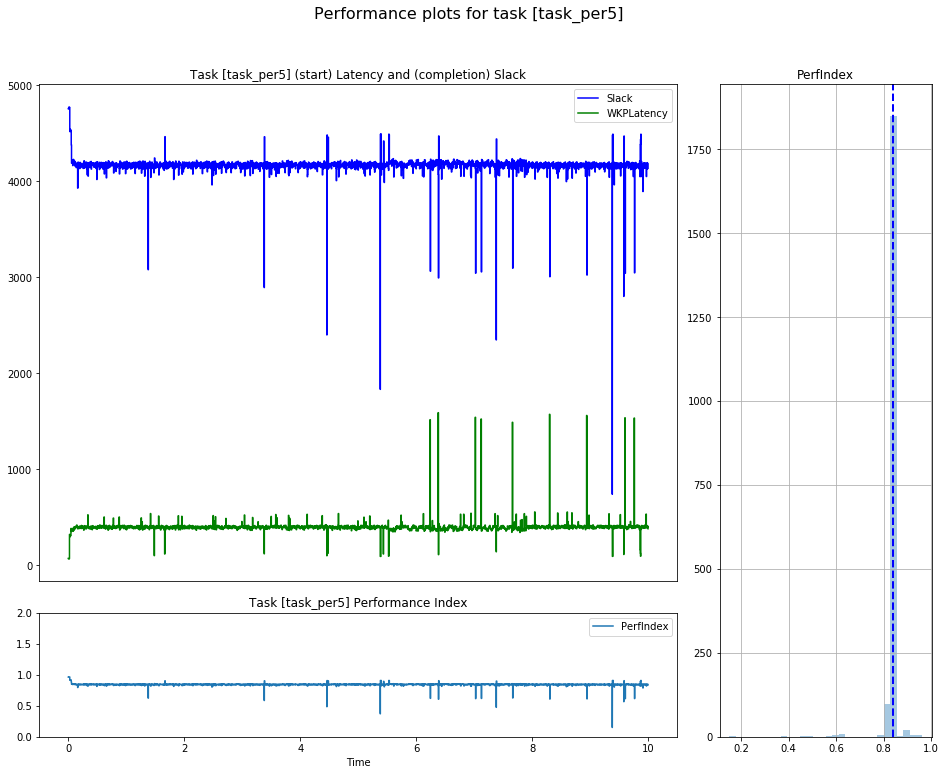

In [16]:
# Parse the RT-App generate log files to compute performance metrics
pa = PerfAnalysis(te.res_dir)

# For each task which has generated a logfile, plot  its performance metrics
for task in pa.tasks():
    pa.plotPerf(task, "Performance plots for task [{}] ".format(task))

In [17]:
# Analyse CPU utilization standard devation
def analysis_energy_calculation_duration():

    df = trace.data_frame.trace_event('sched_energy_calc_duration')
    
    if df.empty:
        return
    
    calc_duration_df = pd.DataFrame(
        {
            'max': [int(df['duration'].max())],
            'min': [int(df['duration'].min())],
            'mean': [int(df['duration'].mean())],
        },
    )
    
    return calc_duration_df

In [18]:
trace = Trace(platform, trace_file, events=my_tests_conf['ftrace']['events'], normalize_time=True)

2018-01-19 11:33:07,115 DEBUG   : Trace        : Loading [sched] events from trace in [/home/leoy/Work/tools/lisa-ml-20171106/results/scheduling_duration_base/trace.dat]...
2018-01-19 11:33:07,117 DEBUG   : Trace        : Parsing events: ['sched_switch', 'cpu_frequency', 'sched_energy_calc_duration', 'cpu_frequency_devlib']
2018-01-19 11:33:07,120 DEBUG   : Trace        : Parsing FTrace format...
/home/leoy/Work/tools/lisa-ml-20171106/libs/trappy/trappy/ftrace.py:273: UserWarning: TRAPpy: Couldn't read <trappy.dynamic.sched_energy_calc_duration object at 0x7f3851f8bfd0> from cache, reading it from trace
  warnings.warn(warnstr)
/home/leoy/Work/tools/lisa-ml-20171106/libs/trappy/trappy/ftrace.py:273: UserWarning: TRAPpy: Couldn't read <trappy.dynamic.cpu_frequency_devlib object at 0x7f3851cd24d0> from cache, reading it from trace
  warnings.warn(warnstr)
2018-01-19 11:33:07,604 DEBUG   : Trace        : Events found on trace:
2018-01-19 11:33:07,605 DEBUG   : Trace        :  - cpu_freque

2018-01-19 11:33:07,837 DEBUG   : Trace        :    cluster_frequency_residency
2018-01-19 11:33:07,840 DEBUG   : Trace        :    cpu_frequency_residency
2018-01-19 11:33:07,842 DEBUG   : Trace        :    trace_event
2018-01-19 11:33:07,843 DEBUG   : Analysis     :    frequency
2018-01-19 11:33:07,849 DEBUG   : Analysis     : Filename: latency_analysis
2018-01-19 11:33:07,853 DEBUG   : Trace        : Registering [<latency_analysis.LatencyAnalysis object at 0x7f3851cd2950>] local data frames
2018-01-19 11:33:07,855 DEBUG   : Trace        :    activations_df
2018-01-19 11:33:07,857 DEBUG   : Trace        :    latency_df
2018-01-19 11:33:07,859 DEBUG   : Trace        :    latency_preemption_df
2018-01-19 11:33:07,860 DEBUG   : Trace        :    latency_wakeup_df
2018-01-19 11:33:07,862 DEBUG   : Trace        :    runtimes_df
2018-01-19 11:33:07,863 DEBUG   : Trace        :    trace_event
2018-01-19 11:33:07,864 DEBUG   : Analysis     :    latency


In [19]:
analysis_energy_calculation_duration()

,max,mean,min
0,54167,11858,3125


# 5% workload

In [20]:
# Create a new RTApp workload generator using the calibration values
# reported by the TestEnv module
rtapp = RTA(target, 'simple', calibration=te.calibration())

# Configure this RTApp instance to:
rtapp.conf(
# 1. generate a "profile based" set of tasks
    kind='profile',
    
    # 2. define the "profile" of each task
    params={

        # 3. PERIODIC task
        # 
        # This class defines a task which load is periodic with a configured
        # period and duty-cycle.
        # 
        # This class is a specialization of the 'pulse' class since a periodic
        # load is generated as a sequence of pulse loads.
        # 
        # Args:
        #     cuty_cycle_pct  (int, [0-100]): the pulses load [%]
        #                                     default: 50[%]
        #     duration_s  (float): the duration in [s] of the entire workload
        #                          default: 1.0[s]
        #     period_ms   (float): the period used to define the load in [ms]
        #                          default: 100.0[ms]
        #     delay_s     (float): the delay in [s] before ramp start
        #                          default: 0[s]
        #     sched       (dict):  the scheduler configuration for this task
        #     cpus      (list): the list of CPUs on which task can run
        'task_per5': Periodic(
            period_ms=5,         # period
            duty_cycle_pct=5,     # duty cycle
            duration_s=10,          # duration
            cpus=None,             # run on all CPUS
            sched={
                "policy": "OTHER",  # Run this task as a SCHED_FIFO task
            },
            delay_s=0              # start at the start of RTApp
        ).get(),
    },
    
    # 7. use this folder for task logfiles
    run_dir=target.working_directory
    
);

2018-01-19 11:33:08,009 INFO    : Workload     : Setup new workload simple
2018-01-19 11:33:08,088 INFO    : Workload     : Workload duration defined by longest task
2018-01-19 11:33:08,090 INFO    : Workload     : Default policy: SCHED_OTHER
2018-01-19 11:33:08,092 INFO    : Workload     : ------------------------
2018-01-19 11:33:08,094 INFO    : Workload     : task [task_per5], sched: {'policy': 'OTHER'}
2018-01-19 11:33:08,095 INFO    : Workload     :  | loops count: 1
2018-01-19 11:33:08,097 INFO    : Workload     : + phase_000001: duration 10.000000 [s] (2000 loops)
2018-01-19 11:33:08,098 INFO    : Workload     : |  period     5000 [us], duty_cycle   5 %
2018-01-19 11:33:08,100 INFO    : Workload     : |  run_time    250 [us], sleep_time   4750 [us]


In [21]:
logging.info('#### Setup FTrace')
te.ftrace.start()

logging.info('#### Start energy sampling')
te.emeter.reset()

logging.info('#### Start RTApp execution')
rtapp.run(out_dir=te.res_dir, cgroup="")

logging.info('#### Read energy consumption: %s/energy.json', te.res_dir)
nrg_report = te.emeter.report(out_dir=te.res_dir)

logging.info('#### Stop FTrace')
te.ftrace.stop()

trace_file = os.path.join(te.res_dir, 'trace.dat')
logging.info('#### Save FTrace: %s', trace_file)
te.ftrace.get_trace(trace_file)

logging.info('#### Save platform description: %s/platform.json', te.res_dir)
(plt, plt_file) = te.platform_dump(te.res_dir)

2018-01-19 11:33:08,175 INFO    : root         : #### Setup FTrace
2018-01-19 11:33:11,236 DEBUG   : FtraceCollector : Trace CPUFreq frequencies
2018-01-19 11:33:11,321 DEBUG   : FtraceCollector : Trace CPUIdle states
2018-01-19 11:33:11,437 INFO    : root         : #### Start energy sampling
2018-01-19 11:33:11,439 DEBUG   : EnergyProbeInstrument : /usr/local/sbin/caiman -d /dev/ttyACM0 -l -r 0:33  /tmp/eprobe-caiman-L2pKh8
2018-01-19 11:33:11,455 INFO    : root         : #### Start RTApp execution
2018-01-19 11:33:11,458 INFO    : Workload     : Workload execution START:
2018-01-19 11:33:11,459 INFO    : Workload     :    /data/local/tmp/bin/rt-app /data/local/tmp/devlib-target/simple_00.json 2>&1


2018-01-19 11:33:21,684 INFO    : root         : #### Read energy consumption: /home/leoy/Work/tools/lisa-ml-20171106/results/scheduling_duration_base/energy.json
2018-01-19 11:33:21,686 DEBUG   : EnergyProbeInstrument : Parsing raw data file: /tmp/eprobe-caiman-L2pKh8/0000000000
2018-01-19 11:33:22,116 INFO    : root         : #### Stop FTrace
2018-01-19 11:33:22,118 DEBUG   : FtraceCollector : Trace CPUFreq frequencies
2018-01-19 11:33:22,348 INFO    : root         : #### Save FTrace: /home/leoy/Work/tools/lisa-ml-20171106/results/scheduling_duration_base/trace.dat
2018-01-19 11:33:24,254 INFO    : root         : #### Save platform description: /home/leoy/Work/tools/lisa-ml-20171106/results/scheduling_duration_base/platform.json


In [22]:
# NOTE: The interactive trace visualization is available only if you run
#       the workload to generate a new trace-file
trappy.plotter.plot_trace(te.res_dir)

/home/leoy/Work/tools/lisa-ml-20171106/libs/trappy/trappy/ftrace.py:200: UserWarning: Cached data is from another trace, invalidating cache.
  warnings.warn(warnstr)


2018-01-19 11:33:25,785 DEBUG   : PerfAnalysis : Found rt-app logfile for task [task_per5]
2018-01-19 11:33:25,786 DEBUG   : PerfAnalysis : Loading dataframe for task [task_per5]...
2018-01-19 11:33:26,039 INFO    : PerfAnalysis : PerfIndex, Task [task_per5] avg: 0.61, std: 0.02


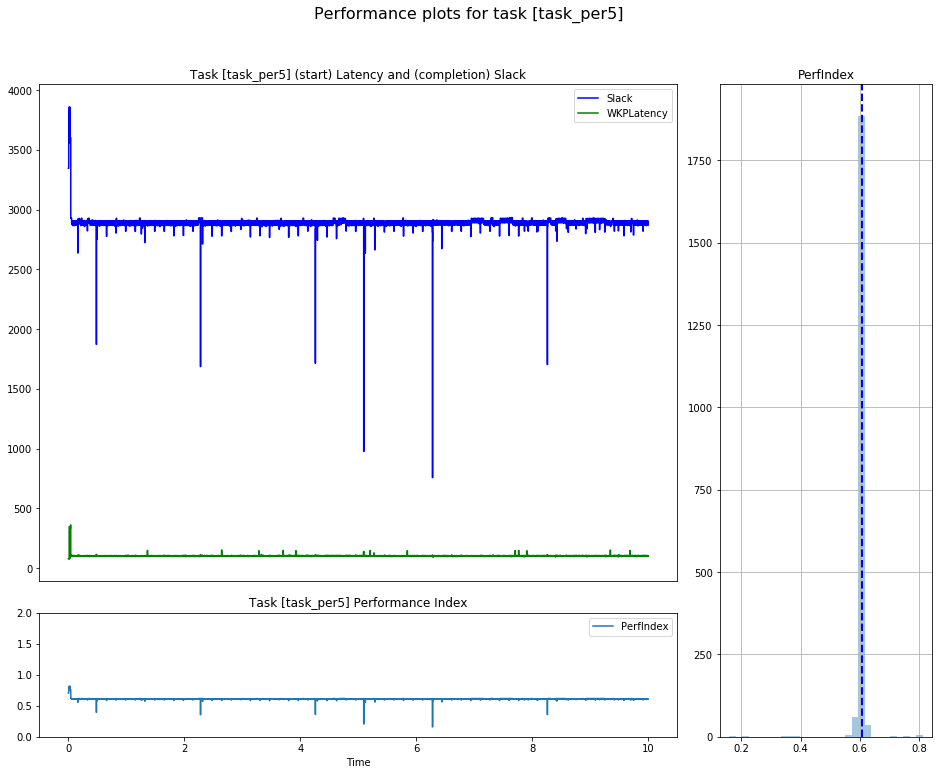

In [23]:
# Parse the RT-App generate log files to compute performance metrics
pa = PerfAnalysis(te.res_dir)

# For each task which has generated a logfile, plot  its performance metrics
for task in pa.tasks():
    pa.plotPerf(task, "Performance plots for task [{}] ".format(task))

In [24]:
trace = Trace(platform, trace_file, events=my_tests_conf['ftrace']['events'], normalize_time=True)

2018-01-19 11:33:27,221 DEBUG   : Trace        : Loading [sched] events from trace in [/home/leoy/Work/tools/lisa-ml-20171106/results/scheduling_duration_base/trace.dat]...
2018-01-19 11:33:27,228 DEBUG   : Trace        : Parsing events: ['sched_switch', 'cpu_frequency', 'sched_energy_calc_duration', 'cpu_frequency_devlib', 'cpu_frequency_devlib']
2018-01-19 11:33:27,231 DEBUG   : Trace        : Parsing FTrace format...
/home/leoy/Work/tools/lisa-ml-20171106/libs/trappy/trappy/ftrace.py:273: UserWarning: TRAPpy: Couldn't read <trappy.dynamic.sched_energy_calc_duration object at 0x7f3851f46910> from cache, reading it from trace
  warnings.warn(warnstr)
/home/leoy/Work/tools/lisa-ml-20171106/libs/trappy/trappy/ftrace.py:273: UserWarning: TRAPpy: Couldn't read <trappy.dynamic.cpu_frequency_devlib object at 0x7f3851f467d0> from cache, reading it from trace
  warnings.warn(warnstr)
2018-01-19 11:33:27,806 DEBUG   : Trace        : Events found on trace:
2018-01-19 11:33:27,807 DEBUG   : Trac

2018-01-19 11:33:27,987 DEBUG   : Trace        : Registering [<frequency_analysis.FrequencyAnalysis object at 0x7f3852953a50>] local data frames
2018-01-19 11:33:27,989 DEBUG   : Trace        :    cluster_frequency_residency
2018-01-19 11:33:27,991 DEBUG   : Trace        :    cpu_frequency_residency
2018-01-19 11:33:27,992 DEBUG   : Trace        :    trace_event
2018-01-19 11:33:27,994 DEBUG   : Analysis     :    frequency
2018-01-19 11:33:27,995 DEBUG   : Analysis     : Filename: latency_analysis
2018-01-19 11:33:27,996 DEBUG   : Trace        : Registering [<latency_analysis.LatencyAnalysis object at 0x7f3851dc64d0>] local data frames
2018-01-19 11:33:27,998 DEBUG   : Trace        :    activations_df
2018-01-19 11:33:27,999 DEBUG   : Trace        :    latency_df
2018-01-19 11:33:28,001 DEBUG   : Trace        :    latency_preemption_df
2018-01-19 11:33:28,002 DEBUG   : Trace        :    latency_wakeup_df
2018-01-19 11:33:28,003 DEBUG   : Trace        :    runtimes_df
2018-01-19 11:33:2

In [25]:
analysis_energy_calculation_duration()

,max,mean,min
0,42188,13028,3645


# 10% workload

In [26]:
# Create a new RTApp workload generator using the calibration values
# reported by the TestEnv module
rtapp = RTA(target, 'simple', calibration=te.calibration())

# Configure this RTApp instance to:
rtapp.conf(
# 1. generate a "profile based" set of tasks
    kind='profile',
    
    # 2. define the "profile" of each task
    params={

        # 3. PERIODIC task
        # 
        # This class defines a task which load is periodic with a configured
        # period and duty-cycle.
        # 
        # This class is a specialization of the 'pulse' class since a periodic
        # load is generated as a sequence of pulse loads.
        # 
        # Args:
        #     cuty_cycle_pct  (int, [0-100]): the pulses load [%]
        #                                     default: 50[%]
        #     duration_s  (float): the duration in [s] of the entire workload
        #                          default: 1.0[s]
        #     period_ms   (float): the period used to define the load in [ms]
        #                          default: 100.0[ms]
        #     delay_s     (float): the delay in [s] before ramp start
        #                          default: 0[s]
        #     sched       (dict):  the scheduler configuration for this task
        #     cpus      (list): the list of CPUs on which task can run
        'task_per5': Periodic(
            period_ms=5,         # period
            duty_cycle_pct=10,     # duty cycle
            duration_s=10,          # duration
            cpus=None,             # run on all CPUS
            sched={
                "policy": "OTHER",  # Run this task as a SCHED_FIFO task
            },
            delay_s=0              # start at the start of RTApp
        ).get(),
    },
    
    # 7. use this folder for task logfiles
    run_dir=target.working_directory
    
);

2018-01-19 11:33:28,135 INFO    : Workload     : Setup new workload simple
2018-01-19 11:33:28,218 INFO    : Workload     : Workload duration defined by longest task
2018-01-19 11:33:28,219 INFO    : Workload     : Default policy: SCHED_OTHER
2018-01-19 11:33:28,222 INFO    : Workload     : ------------------------
2018-01-19 11:33:28,223 INFO    : Workload     : task [task_per5], sched: {'policy': 'OTHER'}
2018-01-19 11:33:28,225 INFO    : Workload     :  | loops count: 1
2018-01-19 11:33:28,226 INFO    : Workload     : + phase_000001: duration 10.000000 [s] (2000 loops)
2018-01-19 11:33:28,228 INFO    : Workload     : |  period     5000 [us], duty_cycle  10 %
2018-01-19 11:33:28,229 INFO    : Workload     : |  run_time    500 [us], sleep_time   4500 [us]


In [27]:
logging.info('#### Setup FTrace')
te.ftrace.start()

logging.info('#### Start energy sampling')
te.emeter.reset()

logging.info('#### Start RTApp execution')
rtapp.run(out_dir=te.res_dir, cgroup="")

logging.info('#### Read energy consumption: %s/energy.json', te.res_dir)
nrg_report = te.emeter.report(out_dir=te.res_dir)

logging.info('#### Stop FTrace')
te.ftrace.stop()

trace_file = os.path.join(te.res_dir, 'trace.dat')
logging.info('#### Save FTrace: %s', trace_file)
te.ftrace.get_trace(trace_file)

logging.info('#### Save platform description: %s/platform.json', te.res_dir)
(plt, plt_file) = te.platform_dump(te.res_dir)

2018-01-19 11:33:28,298 INFO    : root         : #### Setup FTrace
2018-01-19 11:33:31,382 DEBUG   : FtraceCollector : Trace CPUFreq frequencies
2018-01-19 11:33:31,482 DEBUG   : FtraceCollector : Trace CPUIdle states
2018-01-19 11:33:31,596 INFO    : root         : #### Start energy sampling
2018-01-19 11:33:31,598 DEBUG   : EnergyProbeInstrument : /usr/local/sbin/caiman -d /dev/ttyACM0 -l -r 0:33  /tmp/eprobe-caiman-L2pKh8
2018-01-19 11:33:31,608 INFO    : root         : #### Start RTApp execution
2018-01-19 11:33:31,610 INFO    : Workload     : Workload execution START:
2018-01-19 11:33:31,613 INFO    : Workload     :    /data/local/tmp/bin/rt-app /data/local/tmp/devlib-target/simple_00.json 2>&1


2018-01-19 11:33:41,807 INFO    : root         : #### Read energy consumption: /home/leoy/Work/tools/lisa-ml-20171106/results/scheduling_duration_base/energy.json
2018-01-19 11:33:41,809 DEBUG   : EnergyProbeInstrument : Parsing raw data file: /tmp/eprobe-caiman-L2pKh8/0000000000
2018-01-19 11:33:42,304 INFO    : root         : #### Stop FTrace
2018-01-19 11:33:42,305 DEBUG   : FtraceCollector : Trace CPUFreq frequencies
2018-01-19 11:33:42,553 INFO    : root         : #### Save FTrace: /home/leoy/Work/tools/lisa-ml-20171106/results/scheduling_duration_base/trace.dat
2018-01-19 11:33:44,484 INFO    : root         : #### Save platform description: /home/leoy/Work/tools/lisa-ml-20171106/results/scheduling_duration_base/platform.json


In [28]:
# NOTE: The interactive trace visualization is available only if you run
#       the workload to generate a new trace-file
trappy.plotter.plot_trace(te.res_dir)

2018-01-19 11:33:45,765 DEBUG   : PerfAnalysis : Found rt-app logfile for task [task_per5]
2018-01-19 11:33:45,766 DEBUG   : PerfAnalysis : Loading dataframe for task [task_per5]...
2018-01-19 11:33:46,005 INFO    : PerfAnalysis : PerfIndex, Task [task_per5] avg: 0.45, std: 0.20


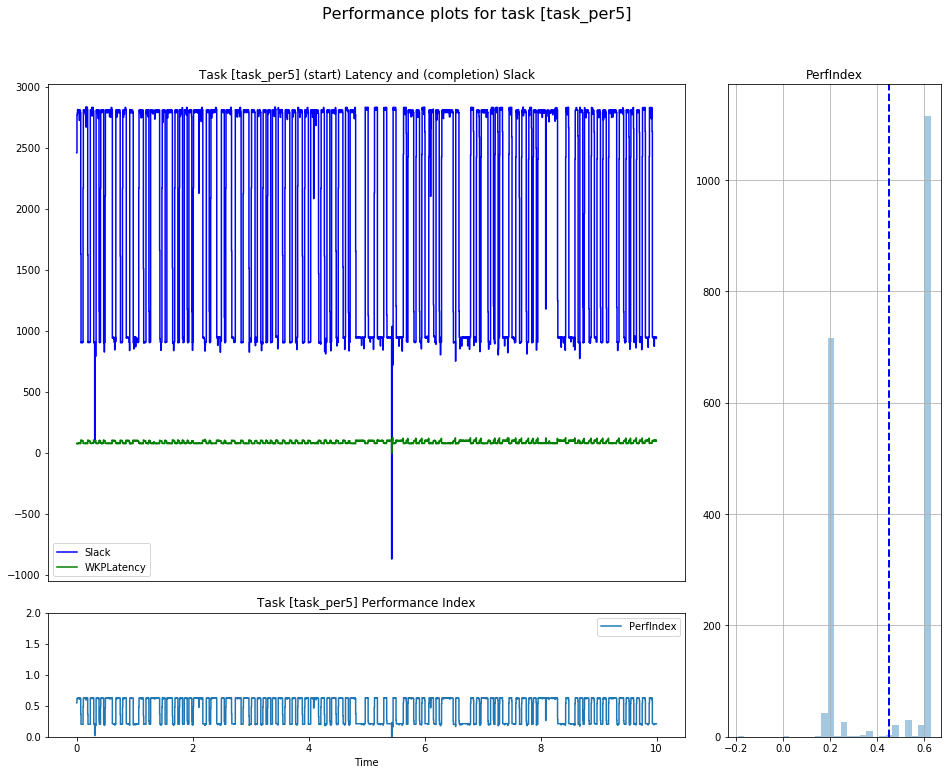

In [29]:
# Parse the RT-App generate log files to compute performance metrics
pa = PerfAnalysis(te.res_dir)

# For each task which has generated a logfile, plot  its performance metrics
for task in pa.tasks():
    pa.plotPerf(task, "Performance plots for task [{}] ".format(task))

In [30]:
trace = Trace(platform, trace_file, events=my_tests_conf['ftrace']['events'], normalize_time=True)

2018-01-19 11:33:47,127 DEBUG   : Trace        : Loading [sched] events from trace in [/home/leoy/Work/tools/lisa-ml-20171106/results/scheduling_duration_base/trace.dat]...
2018-01-19 11:33:47,132 DEBUG   : Trace        : Parsing events: ['sched_switch', 'cpu_frequency', 'sched_energy_calc_duration', 'cpu_frequency_devlib', 'cpu_frequency_devlib', 'cpu_frequency_devlib']
2018-01-19 11:33:47,139 DEBUG   : Trace        : Parsing FTrace format...
/home/leoy/Work/tools/lisa-ml-20171106/libs/trappy/trappy/ftrace.py:273: UserWarning: TRAPpy: Couldn't read <trappy.dynamic.sched_energy_calc_duration object at 0x7f3851d54f50> from cache, reading it from trace
  warnings.warn(warnstr)
/home/leoy/Work/tools/lisa-ml-20171106/libs/trappy/trappy/ftrace.py:273: UserWarning: TRAPpy: Couldn't read <trappy.dynamic.cpu_frequency_devlib object at 0x7f3852d70750> from cache, reading it from trace
  warnings.warn(warnstr)
2018-01-19 11:33:47,642 DEBUG   : Trace        : Events found on trace:
2018-01-19 11:

2018-01-19 11:33:47,915 DEBUG   : Analysis     : Filename: frequency_analysis
2018-01-19 11:33:47,916 DEBUG   : Trace        : Registering [<frequency_analysis.FrequencyAnalysis object at 0x7f3852a68c90>] local data frames
2018-01-19 11:33:47,917 DEBUG   : Trace        :    cluster_frequency_residency
2018-01-19 11:33:47,918 DEBUG   : Trace        :    cpu_frequency_residency
2018-01-19 11:33:47,919 DEBUG   : Trace        :    trace_event
2018-01-19 11:33:47,921 DEBUG   : Analysis     :    frequency
2018-01-19 11:33:47,922 DEBUG   : Analysis     : Filename: latency_analysis
2018-01-19 11:33:47,924 DEBUG   : Trace        : Registering [<latency_analysis.LatencyAnalysis object at 0x7f3852a68210>] local data frames
2018-01-19 11:33:47,925 DEBUG   : Trace        :    activations_df
2018-01-19 11:33:47,926 DEBUG   : Trace        :    latency_df
2018-01-19 11:33:47,927 DEBUG   : Trace        :    latency_preemption_df
2018-01-19 11:33:47,928 DEBUG   : Trace        :    latency_wakeup_df
2018

In [31]:
analysis_energy_calculation_duration()

,max,mean,min
0,29166,9361,2604


# 20% Workload

In [32]:
# Create a new RTApp workload generator using the calibration values
# reported by the TestEnv module
rtapp = RTA(target, 'simple', calibration=te.calibration())

# Configure this RTApp instance to:
rtapp.conf(
# 1. generate a "profile based" set of tasks
    kind='profile',
    
    # 2. define the "profile" of each task
    params={

        # 3. PERIODIC task
        # 
        # This class defines a task which load is periodic with a configured
        # period and duty-cycle.
        # 
        # This class is a specialization of the 'pulse' class since a periodic
        # load is generated as a sequence of pulse loads.
        # 
        # Args:
        #     cuty_cycle_pct  (int, [0-100]): the pulses load [%]
        #                                     default: 50[%]
        #     duration_s  (float): the duration in [s] of the entire workload
        #                          default: 1.0[s]
        #     period_ms   (float): the period used to define the load in [ms]
        #                          default: 100.0[ms]
        #     delay_s     (float): the delay in [s] before ramp start
        #                          default: 0[s]
        #     sched       (dict):  the scheduler configuration for this task
        #     cpus      (list): the list of CPUs on which task can run
        'task_per5': Periodic(
            period_ms=5,         # period
            duty_cycle_pct=20,     # duty cycle
            duration_s=10,          # duration
            cpus=None,             # run on all CPUS
            sched={
                "policy": "OTHER",  # Run this task as a SCHED_FIFO task
            },
            delay_s=0              # start at the start of RTApp
        ).get(),
    },
    
    # 7. use this folder for task logfiles
    run_dir=target.working_directory
    
);

2018-01-19 11:33:48,066 INFO    : Workload     : Setup new workload simple
2018-01-19 11:33:48,163 INFO    : Workload     : Workload duration defined by longest task
2018-01-19 11:33:48,164 INFO    : Workload     : Default policy: SCHED_OTHER
2018-01-19 11:33:48,166 INFO    : Workload     : ------------------------
2018-01-19 11:33:48,167 INFO    : Workload     : task [task_per5], sched: {'policy': 'OTHER'}
2018-01-19 11:33:48,168 INFO    : Workload     :  | loops count: 1
2018-01-19 11:33:48,169 INFO    : Workload     : + phase_000001: duration 10.000000 [s] (2000 loops)
2018-01-19 11:33:48,170 INFO    : Workload     : |  period     5000 [us], duty_cycle  20 %
2018-01-19 11:33:48,171 INFO    : Workload     : |  run_time   1000 [us], sleep_time   4000 [us]


In [33]:
logging.info('#### Setup FTrace')
te.ftrace.start()

logging.info('#### Start energy sampling')
te.emeter.reset()

logging.info('#### Start RTApp execution')
rtapp.run(out_dir=te.res_dir, cgroup="")

logging.info('#### Read energy consumption: %s/energy.json', te.res_dir)
nrg_report = te.emeter.report(out_dir=te.res_dir)

logging.info('#### Stop FTrace')
te.ftrace.stop()

trace_file = os.path.join(te.res_dir, 'trace.dat')
logging.info('#### Save FTrace: %s', trace_file)
te.ftrace.get_trace(trace_file)

logging.info('#### Save platform description: %s/platform.json', te.res_dir)
(plt, plt_file) = te.platform_dump(te.res_dir)

2018-01-19 11:33:48,212 INFO    : root         : #### Setup FTrace
2018-01-19 11:33:51,315 DEBUG   : FtraceCollector : Trace CPUFreq frequencies
2018-01-19 11:33:51,421 DEBUG   : FtraceCollector : Trace CPUIdle states
2018-01-19 11:33:51,539 INFO    : root         : #### Start energy sampling
2018-01-19 11:33:51,541 DEBUG   : EnergyProbeInstrument : /usr/local/sbin/caiman -d /dev/ttyACM0 -l -r 0:33  /tmp/eprobe-caiman-L2pKh8
2018-01-19 11:33:51,555 INFO    : root         : #### Start RTApp execution
2018-01-19 11:33:51,557 INFO    : Workload     : Workload execution START:
2018-01-19 11:33:51,559 INFO    : Workload     :    /data/local/tmp/bin/rt-app /data/local/tmp/devlib-target/simple_00.json 2>&1


2018-01-19 11:34:01,763 INFO    : root         : #### Read energy consumption: /home/leoy/Work/tools/lisa-ml-20171106/results/scheduling_duration_base/energy.json
2018-01-19 11:34:01,765 DEBUG   : EnergyProbeInstrument : Parsing raw data file: /tmp/eprobe-caiman-L2pKh8/0000000000
2018-01-19 11:34:02,164 INFO    : root         : #### Stop FTrace
2018-01-19 11:34:02,165 DEBUG   : FtraceCollector : Trace CPUFreq frequencies
2018-01-19 11:34:02,409 INFO    : root         : #### Save FTrace: /home/leoy/Work/tools/lisa-ml-20171106/results/scheduling_duration_base/trace.dat
2018-01-19 11:34:04,316 INFO    : root         : #### Save platform description: /home/leoy/Work/tools/lisa-ml-20171106/results/scheduling_duration_base/platform.json


In [34]:
# NOTE: The interactive trace visualization is available only if you run
#       the workload to generate a new trace-file
trappy.plotter.plot_trace(te.res_dir)

2018-01-19 11:34:05,890 DEBUG   : PerfAnalysis : Found rt-app logfile for task [task_per5]
2018-01-19 11:34:05,891 DEBUG   : PerfAnalysis : Loading dataframe for task [task_per5]...
2018-01-19 11:34:06,121 INFO    : PerfAnalysis : PerfIndex, Task [task_per5] avg: 0.48, std: 0.02


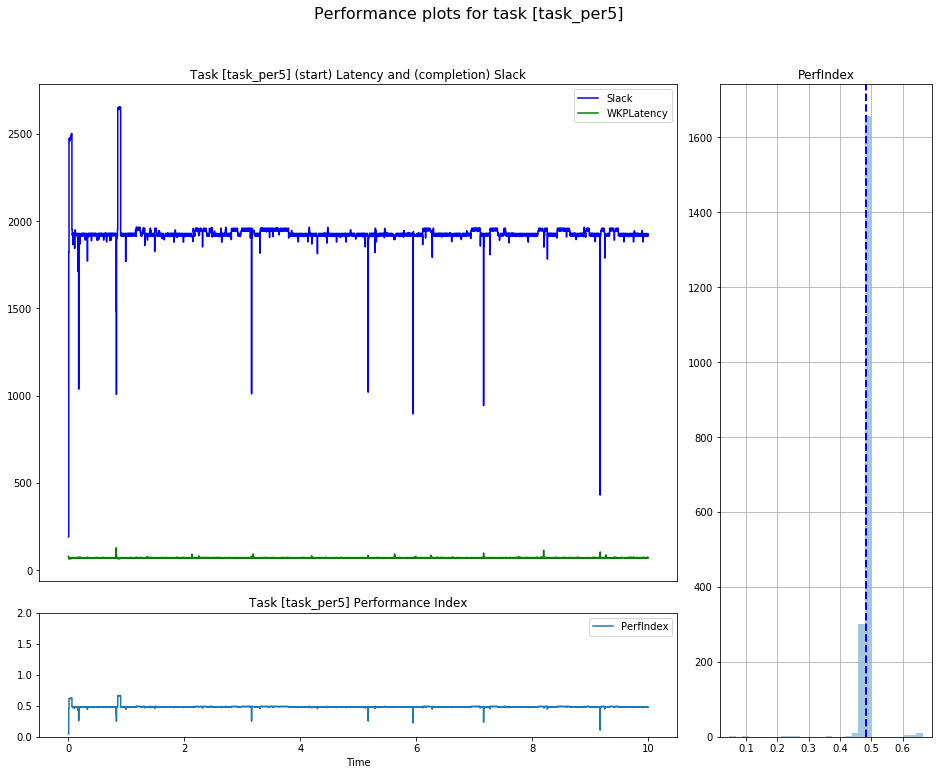

In [35]:
# Parse the RT-App generate log files to compute performance metrics
pa = PerfAnalysis(te.res_dir)

# For each task which has generated a logfile, plot  its performance metrics
for task in pa.tasks():
    pa.plotPerf(task, "Performance plots for task [{}] ".format(task))

In [36]:
trace = Trace(platform, trace_file, events=my_tests_conf['ftrace']['events'], normalize_time=True)

2018-01-19 11:34:07,100 DEBUG   : Trace        : Loading [sched] events from trace in [/home/leoy/Work/tools/lisa-ml-20171106/results/scheduling_duration_base/trace.dat]...
2018-01-19 11:34:07,102 DEBUG   : Trace        : Parsing events: ['sched_switch', 'cpu_frequency', 'sched_energy_calc_duration', 'cpu_frequency_devlib', 'cpu_frequency_devlib', 'cpu_frequency_devlib', 'cpu_frequency_devlib']
2018-01-19 11:34:07,103 DEBUG   : Trace        : Parsing FTrace format...
/home/leoy/Work/tools/lisa-ml-20171106/libs/trappy/trappy/ftrace.py:273: UserWarning: TRAPpy: Couldn't read <trappy.dynamic.sched_energy_calc_duration object at 0x7f3851e5c590> from cache, reading it from trace
  warnings.warn(warnstr)
/home/leoy/Work/tools/lisa-ml-20171106/libs/trappy/trappy/ftrace.py:273: UserWarning: TRAPpy: Couldn't read <trappy.dynamic.cpu_frequency_devlib object at 0x7f3852de5f90> from cache, reading it from trace
  warnings.warn(warnstr)
2018-01-19 11:34:07,602 DEBUG   : Trace        : Events found 

2018-01-19 11:34:07,810 DEBUG   : Analysis     :    idle
2018-01-19 11:34:07,811 DEBUG   : Analysis     : Filename: frequency_analysis
2018-01-19 11:34:07,813 DEBUG   : Trace        : Registering [<frequency_analysis.FrequencyAnalysis object at 0x7f3851f8bd50>] local data frames
2018-01-19 11:34:07,815 DEBUG   : Trace        :    cluster_frequency_residency
2018-01-19 11:34:07,816 DEBUG   : Trace        :    cpu_frequency_residency
2018-01-19 11:34:07,818 DEBUG   : Trace        :    trace_event
2018-01-19 11:34:07,819 DEBUG   : Analysis     :    frequency
2018-01-19 11:34:07,820 DEBUG   : Analysis     : Filename: latency_analysis
2018-01-19 11:34:07,821 DEBUG   : Trace        : Registering [<latency_analysis.LatencyAnalysis object at 0x7f3851f8b850>] local data frames
2018-01-19 11:34:07,823 DEBUG   : Trace        :    activations_df
2018-01-19 11:34:07,824 DEBUG   : Trace        :    latency_df
2018-01-19 11:34:07,825 DEBUG   : Trace        :    latency_preemption_df
2018-01-19 11:34:

In [37]:
analysis_energy_calculation_duration()

,max,mean,min
0,35937,10736,3646


# 30% Workload

In [38]:
# Create a new RTApp workload generator using the calibration values
# reported by the TestEnv module
rtapp = RTA(target, 'simple', calibration=te.calibration())

# Configure this RTApp instance to:
rtapp.conf(
# 1. generate a "profile based" set of tasks
    kind='profile',
    
    # 2. define the "profile" of each task
    params={

        # 3. PERIODIC task
        # 
        # This class defines a task which load is periodic with a configured
        # period and duty-cycle.
        # 
        # This class is a specialization of the 'pulse' class since a periodic
        # load is generated as a sequence of pulse loads.
        # 
        # Args:
        #     cuty_cycle_pct  (int, [0-100]): the pulses load [%]
        #                                     default: 50[%]
        #     duration_s  (float): the duration in [s] of the entire workload
        #                          default: 1.0[s]
        #     period_ms   (float): the period used to define the load in [ms]
        #                          default: 100.0[ms]
        #     delay_s     (float): the delay in [s] before ramp start
        #                          default: 0[s]
        #     sched       (dict):  the scheduler configuration for this task
        #     cpus      (list): the list of CPUs on which task can run
        'task_per5': Periodic(
            period_ms=5,         # period
            duty_cycle_pct=30,     # duty cycle
            duration_s=10,          # duration
            cpus=None,             # run on all CPUS
            sched={
                "policy": "OTHER",  # Run this task as a SCHED_FIFO task
            },
            delay_s=0              # start at the start of RTApp
        ).get(),
    },
    
    # 7. use this folder for task logfiles
    run_dir=target.working_directory
    
);

2018-01-19 11:34:07,991 INFO    : Workload     : Setup new workload simple
2018-01-19 11:34:08,056 INFO    : Workload     : Workload duration defined by longest task
2018-01-19 11:34:08,057 INFO    : Workload     : Default policy: SCHED_OTHER
2018-01-19 11:34:08,058 INFO    : Workload     : ------------------------
2018-01-19 11:34:08,059 INFO    : Workload     : task [task_per5], sched: {'policy': 'OTHER'}
2018-01-19 11:34:08,061 INFO    : Workload     :  | loops count: 1
2018-01-19 11:34:08,062 INFO    : Workload     : + phase_000001: duration 10.000000 [s] (2000 loops)
2018-01-19 11:34:08,064 INFO    : Workload     : |  period     5000 [us], duty_cycle  30 %
2018-01-19 11:34:08,065 INFO    : Workload     : |  run_time   1500 [us], sleep_time   3500 [us]


In [39]:
logging.info('#### Setup FTrace')
te.ftrace.start()

logging.info('#### Start energy sampling')
te.emeter.reset()

logging.info('#### Start RTApp execution')
rtapp.run(out_dir=te.res_dir, cgroup="")

logging.info('#### Read energy consumption: %s/energy.json', te.res_dir)
nrg_report = te.emeter.report(out_dir=te.res_dir)

logging.info('#### Stop FTrace')
te.ftrace.stop()

trace_file = os.path.join(te.res_dir, 'trace.dat')
logging.info('#### Save FTrace: %s', trace_file)
te.ftrace.get_trace(trace_file)

logging.info('#### Save platform description: %s/platform.json', te.res_dir)
(plt, plt_file) = te.platform_dump(te.res_dir)

2018-01-19 11:34:08,134 INFO    : root         : #### Setup FTrace
2018-01-19 11:34:11,210 DEBUG   : FtraceCollector : Trace CPUFreq frequencies
2018-01-19 11:34:11,286 DEBUG   : FtraceCollector : Trace CPUIdle states
2018-01-19 11:34:11,397 INFO    : root         : #### Start energy sampling
2018-01-19 11:34:11,398 DEBUG   : EnergyProbeInstrument : /usr/local/sbin/caiman -d /dev/ttyACM0 -l -r 0:33  /tmp/eprobe-caiman-L2pKh8
2018-01-19 11:34:11,411 INFO    : root         : #### Start RTApp execution
2018-01-19 11:34:11,413 INFO    : Workload     : Workload execution START:
2018-01-19 11:34:11,415 INFO    : Workload     :    /data/local/tmp/bin/rt-app /data/local/tmp/devlib-target/simple_00.json 2>&1


2018-01-19 11:34:21,579 INFO    : root         : #### Read energy consumption: /home/leoy/Work/tools/lisa-ml-20171106/results/scheduling_duration_base/energy.json
2018-01-19 11:34:21,581 DEBUG   : EnergyProbeInstrument : Parsing raw data file: /tmp/eprobe-caiman-L2pKh8/0000000000
2018-01-19 11:34:22,000 INFO    : root         : #### Stop FTrace
2018-01-19 11:34:22,001 DEBUG   : FtraceCollector : Trace CPUFreq frequencies
2018-01-19 11:34:22,231 INFO    : root         : #### Save FTrace: /home/leoy/Work/tools/lisa-ml-20171106/results/scheduling_duration_base/trace.dat
2018-01-19 11:34:24,142 INFO    : root         : #### Save platform description: /home/leoy/Work/tools/lisa-ml-20171106/results/scheduling_duration_base/platform.json


In [40]:
# NOTE: The interactive trace visualization is available only if you run
#       the workload to generate a new trace-file
trappy.plotter.plot_trace(te.res_dir)

2018-01-19 11:34:25,525 DEBUG   : PerfAnalysis : Found rt-app logfile for task [task_per5]
2018-01-19 11:34:25,526 DEBUG   : PerfAnalysis : Loading dataframe for task [task_per5]...
2018-01-19 11:34:25,761 INFO    : PerfAnalysis : PerfIndex, Task [task_per5] avg: 0.36, std: 0.02


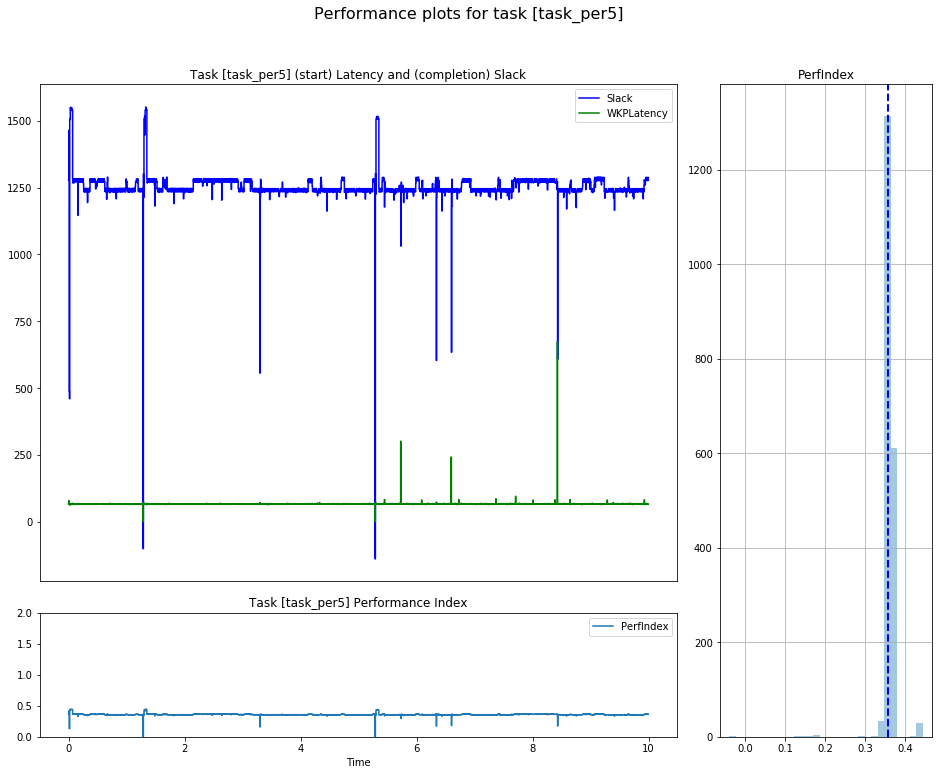

In [41]:
# Parse the RT-App generate log files to compute performance metrics
pa = PerfAnalysis(te.res_dir)

# For each task which has generated a logfile, plot  its performance metrics
for task in pa.tasks():
    pa.plotPerf(task, "Performance plots for task [{}] ".format(task))

In [42]:
trace = Trace(platform, trace_file, events=my_tests_conf['ftrace']['events'], normalize_time=True)

2018-01-19 11:34:26,875 DEBUG   : Trace        : Loading [sched] events from trace in [/home/leoy/Work/tools/lisa-ml-20171106/results/scheduling_duration_base/trace.dat]...
2018-01-19 11:34:26,878 DEBUG   : Trace        : Parsing events: ['sched_switch', 'cpu_frequency', 'sched_energy_calc_duration', 'cpu_frequency_devlib', 'cpu_frequency_devlib', 'cpu_frequency_devlib', 'cpu_frequency_devlib', 'cpu_frequency_devlib']
2018-01-19 11:34:26,879 DEBUG   : Trace        : Parsing FTrace format...
/home/leoy/Work/tools/lisa-ml-20171106/libs/trappy/trappy/ftrace.py:273: UserWarning: TRAPpy: Couldn't read <trappy.dynamic.sched_energy_calc_duration object at 0x7f3852de5990> from cache, reading it from trace
  warnings.warn(warnstr)
/home/leoy/Work/tools/lisa-ml-20171106/libs/trappy/trappy/ftrace.py:273: UserWarning: TRAPpy: Couldn't read <trappy.dynamic.cpu_frequency_devlib object at 0x7f3852169310> from cache, reading it from trace
  warnings.warn(warnstr)
2018-01-19 11:34:27,375 DEBUG   : Trac

2018-01-19 11:34:27,577 DEBUG   : Analysis     : Filename: frequency_analysis
2018-01-19 11:34:27,578 DEBUG   : Trace        : Registering [<frequency_analysis.FrequencyAnalysis object at 0x7f385297e750>] local data frames
2018-01-19 11:34:27,580 DEBUG   : Trace        :    cluster_frequency_residency
2018-01-19 11:34:27,581 DEBUG   : Trace        :    cpu_frequency_residency
2018-01-19 11:34:27,582 DEBUG   : Trace        :    trace_event
2018-01-19 11:34:27,584 DEBUG   : Analysis     :    frequency
2018-01-19 11:34:27,585 DEBUG   : Analysis     : Filename: latency_analysis
2018-01-19 11:34:27,587 DEBUG   : Trace        : Registering [<latency_analysis.LatencyAnalysis object at 0x7f385297ef10>] local data frames
2018-01-19 11:34:27,588 DEBUG   : Trace        :    activations_df
2018-01-19 11:34:27,589 DEBUG   : Trace        :    latency_df
2018-01-19 11:34:27,591 DEBUG   : Trace        :    latency_preemption_df
2018-01-19 11:34:27,592 DEBUG   : Trace        :    latency_wakeup_df
2018

In [43]:
analysis_energy_calculation_duration()

,max,mean,min
0,30208,8216,3645


# 40% Workload

In [44]:
# Create a new RTApp workload generator using the calibration values
# reported by the TestEnv module
rtapp = RTA(target, 'simple', calibration=te.calibration())

# Configure this RTApp instance to:
rtapp.conf(
# 1. generate a "profile based" set of tasks
    kind='profile',
    
    # 2. define the "profile" of each task
    params={

        # 3. PERIODIC task
        # 
        # This class defines a task which load is periodic with a configured
        # period and duty-cycle.
        # 
        # This class is a specialization of the 'pulse' class since a periodic
        # load is generated as a sequence of pulse loads.
        # 
        # Args:
        #     cuty_cycle_pct  (int, [0-100]): the pulses load [%]
        #                                     default: 50[%]
        #     duration_s  (float): the duration in [s] of the entire workload
        #                          default: 1.0[s]
        #     period_ms   (float): the period used to define the load in [ms]
        #                          default: 100.0[ms]
        #     delay_s     (float): the delay in [s] before ramp start
        #                          default: 0[s]
        #     sched       (dict):  the scheduler configuration for this task
        #     cpus      (list): the list of CPUs on which task can run
        'task_per5': Periodic(
            period_ms=5,         # period
            duty_cycle_pct=40,     # duty cycle
            duration_s=10,          # duration
            cpus=None,             # run on all CPUS
            sched={
                "policy": "OTHER",  # Run this task as a SCHED_FIFO task
            },
            delay_s=0              # start at the start of RTApp
        ).get(),
    },
    
    # 7. use this folder for task logfiles
    run_dir=target.working_directory
    
);

2018-01-19 11:34:27,721 INFO    : Workload     : Setup new workload simple
2018-01-19 11:34:27,816 INFO    : Workload     : Workload duration defined by longest task
2018-01-19 11:34:27,818 INFO    : Workload     : Default policy: SCHED_OTHER
2018-01-19 11:34:27,819 INFO    : Workload     : ------------------------
2018-01-19 11:34:27,820 INFO    : Workload     : task [task_per5], sched: {'policy': 'OTHER'}
2018-01-19 11:34:27,822 INFO    : Workload     :  | loops count: 1
2018-01-19 11:34:27,823 INFO    : Workload     : + phase_000001: duration 10.000000 [s] (2000 loops)
2018-01-19 11:34:27,825 INFO    : Workload     : |  period     5000 [us], duty_cycle  40 %
2018-01-19 11:34:27,826 INFO    : Workload     : |  run_time   2000 [us], sleep_time   3000 [us]


In [45]:
logging.info('#### Setup FTrace')
te.ftrace.start()

logging.info('#### Start energy sampling')
te.emeter.reset()

logging.info('#### Start RTApp execution')
rtapp.run(out_dir=te.res_dir, cgroup="")

logging.info('#### Read energy consumption: %s/energy.json', te.res_dir)
nrg_report = te.emeter.report(out_dir=te.res_dir)

logging.info('#### Stop FTrace')
te.ftrace.stop()

trace_file = os.path.join(te.res_dir, 'trace.dat')
logging.info('#### Save FTrace: %s', trace_file)
te.ftrace.get_trace(trace_file)

logging.info('#### Save platform description: %s/platform.json', te.res_dir)
(plt, plt_file) = te.platform_dump(te.res_dir)

2018-01-19 11:34:27,869 INFO    : root         : #### Setup FTrace
2018-01-19 11:34:31,038 DEBUG   : FtraceCollector : Trace CPUFreq frequencies
2018-01-19 11:34:31,107 DEBUG   : FtraceCollector : Trace CPUIdle states
2018-01-19 11:34:31,211 INFO    : root         : #### Start energy sampling
2018-01-19 11:34:31,213 DEBUG   : EnergyProbeInstrument : /usr/local/sbin/caiman -d /dev/ttyACM0 -l -r 0:33  /tmp/eprobe-caiman-L2pKh8
2018-01-19 11:34:31,230 INFO    : root         : #### Start RTApp execution
2018-01-19 11:34:31,233 INFO    : Workload     : Workload execution START:
2018-01-19 11:34:31,235 INFO    : Workload     :    /data/local/tmp/bin/rt-app /data/local/tmp/devlib-target/simple_00.json 2>&1


2018-01-19 11:34:41,479 INFO    : root         : #### Read energy consumption: /home/leoy/Work/tools/lisa-ml-20171106/results/scheduling_duration_base/energy.json
2018-01-19 11:34:41,481 DEBUG   : EnergyProbeInstrument : Parsing raw data file: /tmp/eprobe-caiman-L2pKh8/0000000000
2018-01-19 11:34:41,834 INFO    : root         : #### Stop FTrace
2018-01-19 11:34:41,835 DEBUG   : FtraceCollector : Trace CPUFreq frequencies
2018-01-19 11:34:42,063 INFO    : root         : #### Save FTrace: /home/leoy/Work/tools/lisa-ml-20171106/results/scheduling_duration_base/trace.dat
2018-01-19 11:34:43,972 INFO    : root         : #### Save platform description: /home/leoy/Work/tools/lisa-ml-20171106/results/scheduling_duration_base/platform.json


In [46]:
# NOTE: The interactive trace visualization is available only if you run
#       the workload to generate a new trace-file
trappy.plotter.plot_trace(te.res_dir)

2018-01-19 11:34:45,411 DEBUG   : PerfAnalysis : Found rt-app logfile for task [task_per5]
2018-01-19 11:34:45,413 DEBUG   : PerfAnalysis : Loading dataframe for task [task_per5]...
2018-01-19 11:34:45,645 INFO    : PerfAnalysis : PerfIndex, Task [task_per5] avg: 0.51, std: 0.07


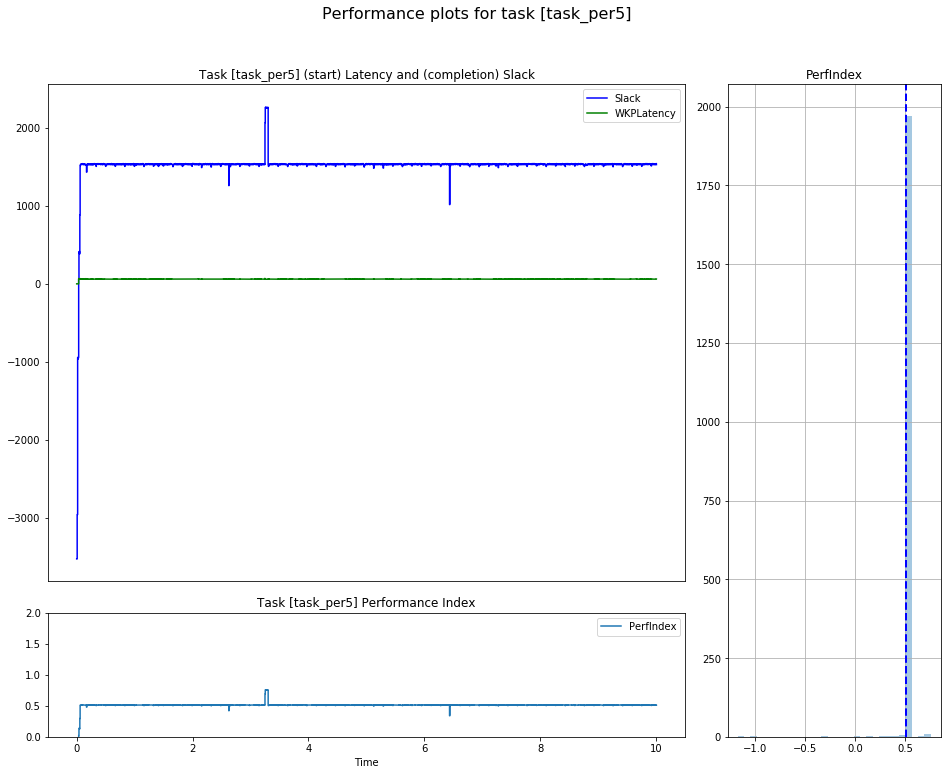

In [47]:
# Parse the RT-App generate log files to compute performance metrics
pa = PerfAnalysis(te.res_dir)

# For each task which has generated a logfile, plot  its performance metrics
for task in pa.tasks():
    pa.plotPerf(task, "Performance plots for task [{}] ".format(task))

In [48]:
trace = Trace(platform, trace_file, events=my_tests_conf['ftrace']['events'], normalize_time=True)

2018-01-19 11:34:46,747 DEBUG   : Trace        : Loading [sched] events from trace in [/home/leoy/Work/tools/lisa-ml-20171106/results/scheduling_duration_base/trace.dat]...
2018-01-19 11:34:46,749 DEBUG   : Trace        : Parsing events: ['sched_switch', 'cpu_frequency', 'sched_energy_calc_duration', 'cpu_frequency_devlib', 'cpu_frequency_devlib', 'cpu_frequency_devlib', 'cpu_frequency_devlib', 'cpu_frequency_devlib', 'cpu_frequency_devlib']
2018-01-19 11:34:46,750 DEBUG   : Trace        : Parsing FTrace format...
/home/leoy/Work/tools/lisa-ml-20171106/libs/trappy/trappy/ftrace.py:273: UserWarning: TRAPpy: Couldn't read <trappy.dynamic.sched_energy_calc_duration object at 0x7f3851f52710> from cache, reading it from trace
  warnings.warn(warnstr)
/home/leoy/Work/tools/lisa-ml-20171106/libs/trappy/trappy/ftrace.py:273: UserWarning: TRAPpy: Couldn't read <trappy.dynamic.cpu_frequency_devlib object at 0x7f3851f52250> from cache, reading it from trace
  warnings.warn(warnstr)
2018-01-19 11:

2018-01-19 11:34:47,395 DEBUG   : Analysis     :    idle
2018-01-19 11:34:47,396 DEBUG   : Analysis     : Filename: frequency_analysis
2018-01-19 11:34:47,397 DEBUG   : Trace        : Registering [<frequency_analysis.FrequencyAnalysis object at 0x7f3852d72590>] local data frames
2018-01-19 11:34:47,398 DEBUG   : Trace        :    cluster_frequency_residency
2018-01-19 11:34:47,399 DEBUG   : Trace        :    cpu_frequency_residency
2018-01-19 11:34:47,400 DEBUG   : Trace        :    trace_event
2018-01-19 11:34:47,401 DEBUG   : Analysis     :    frequency
2018-01-19 11:34:47,402 DEBUG   : Analysis     : Filename: latency_analysis
2018-01-19 11:34:47,403 DEBUG   : Trace        : Registering [<latency_analysis.LatencyAnalysis object at 0x7f3852d72a50>] local data frames
2018-01-19 11:34:47,404 DEBUG   : Trace        :    activations_df
2018-01-19 11:34:47,405 DEBUG   : Trace        :    latency_df
2018-01-19 11:34:47,405 DEBUG   : Trace        :    latency_preemption_df
2018-01-19 11:34:

In [49]:
analysis_energy_calculation_duration()

,max,mean,min
0,44271,15222,3125
